In [2]:
import math
import torch
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
import requests

# alphavantage
apikey = "8AXHO0L0AM7BQJQ5"

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=SPY&extended_hours=false&interval=1min&outputsize=full&apikey={apikey}'
r = requests.get(url)
data = r.json()

In [120]:
ts = data['Time Series (1min)']
rows = [[k, v['1. open'], v['4. close'], v['5. volume']] for k,v in ts.items()]
spy = pd.DataFrame(rows, columns=['timestamp', 'open', 'close', 'volume'])[::-1]
spy.index = spy['timestamp']
spy.drop(['timestamp'], axis=1, inplace=True)
spy.index = pd.to_datetime(spy.index)
spy = spy.astype({'open':'float', 'close':'float', 'volume':'float'})

In [121]:
# make sure full day exists
def complete_info(group):
    open = pd.Timestamp("9:30:00").time()
    close = pd.Timestamp("15:59:00").time()
    times = group.index.time
    return open in times and close in times

grouped = spy.groupby(spy.index.date)
df = grouped.filter(complete_info)

In [223]:
from datetime import datetime, time, timedelta

def return_0_t(x):
    op = x.iloc[0]['open']
    return (x['close'] - op) / op

def return_t_T(x):
    cp = x.iloc[-1]['close']
    return (cp - x['open']) / x['open']

def t_td(t):
    return timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)

def day_frac(x):
    market_open = pd.Timestamp("9:30:00").time()
    market_close = pd.Timestamp("15:59:00").time()
    return (t_td(x) - t_td(market_open)) / (t_td(market_close) - t_td(market_open))

df['r0_t'] = df.groupby(df.index.date).apply(return_0_t).tolist()
df['rt_T'] = df.groupby(df.index.date).apply(return_t_T).tolist()
df['dfrac'] = df.index.to_series().apply(day_frac)
df['avg_vol'] = df.groupby(df.index.date)['volume'].cumsum() / (
    df.groupby(df.index.date).cumcount() + 1)

df['avg_vol'] = (df['avg_vol'] - df['avg_vol'].mean()) / df['avg_vol'].std()


In [230]:
x = torch.tensor(df[['r0_t', 'dfrac', 'avg_vol']].values)
y = torch.tensor(df[['rt_T']].values)

In [297]:
train_x = x[::2]
train_y = y[::2].reshape((len(y[::2])))

print(train_x.shape, train_y.shape)

torch.Size([3120, 3]) torch.Size([3120])


In [298]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [299]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    #print(len(loss))
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.748   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.711   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.672   lengthscale: 0.797   noise: 0.598
Iter 4/50 - Loss: 0.634   lengthscale: 0.851   noise: 0.554
Iter 5/50 - Loss: 0.594   lengthscale: 0.907   noise: 0.513
Iter 6/50 - Loss: 0.554   lengthscale: 0.963   noise: 0.474
Iter 7/50 - Loss: 0.513   lengthscale: 1.019   noise: 0.437
Iter 8/50 - Loss: 0.472   lengthscale: 1.077   noise: 0.403
Iter 9/50 - Loss: 0.430   lengthscale: 1.136   noise: 0.370
Iter 10/50 - Loss: 0.387   lengthscale: 1.196   noise: 0.340
Iter 11/50 - Loss: 0.344   lengthscale: 1.256   noise: 0.312
Iter 12/50 - Loss: 0.299   lengthscale: 1.317   noise: 0.286
Iter 13/50 - Loss: 0.255   lengthscale: 1.377   noise: 0.261
Iter 14/50 - Loss: 0.209   lengthscale: 1.436   noise: 0.239
Iter 15/50 - Loss: 0.163   lengthscale: 1.496   noise: 0.218
Iter 16/50 - Loss: 0.117   lengthscale: 1.555   noise: 0.199
Iter 17/50 - Loss: 0.070   length

In [329]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_r = torch.linspace(-1, 1, 100)
    test_f = torch.linspace(0, 1, 100)
    test_v = torch.linspace(-3, 3, 100)
    test_x = torch.stack((test_r, test_f, test_v), -1)
    
    observed_pred = likelihood(model(test_x))
    t = likelihood(model(torch.tensor([[-0.1, 0.99, 0]])))

In [330]:
t.confidence_region()

(tensor([-0.1515], dtype=torch.float64), tensor([0.1482], dtype=torch.float64))

In [309]:
observed_pred.confidence_region()

(tensor([-0.1688, -0.1676, -0.1664, -0.1652, -0.1642, -0.1631, -0.1621, -0.1612,
         -0.1603, -0.1594, -0.1586, -0.1579, -0.1572, -0.1565, -0.1559, -0.1553,
         -0.1547, -0.1542, -0.1538, -0.1533, -0.1529, -0.1526, -0.1523, -0.1520,
         -0.1517, -0.1515, -0.1512, -0.1511, -0.1509, -0.1508, -0.1507, -0.1506,
         -0.1505, -0.1504, -0.1504, -0.1504, -0.1504, -0.1504, -0.1505, -0.1505,
         -0.1506, -0.1506, -0.1507, -0.1508, -0.1510, -0.1511, -0.1512, -0.1514,
         -0.1515, -0.1517, -0.1519, -0.1521, -0.1523, -0.1525, -0.1527, -0.1530,
         -0.1532, -0.1535, -0.1538, -0.1540, -0.1543, -0.1546, -0.1550, -0.1553,
         -0.1556, -0.1560, -0.1564, -0.1568, -0.1572, -0.1576, -0.1580, -0.1584,
         -0.1589, -0.1594, -0.1598, -0.1603, -0.1609, -0.1614, -0.1619, -0.1625,
         -0.1631, -0.1637, -0.1643, -0.1649, -0.1656, -0.1662, -0.1669, -0.1676,
         -0.1683, -0.1691, -0.1698, -0.1706, -0.1714, -0.1721, -0.1730, -0.1738,
         -0.1746, -0.1755, -

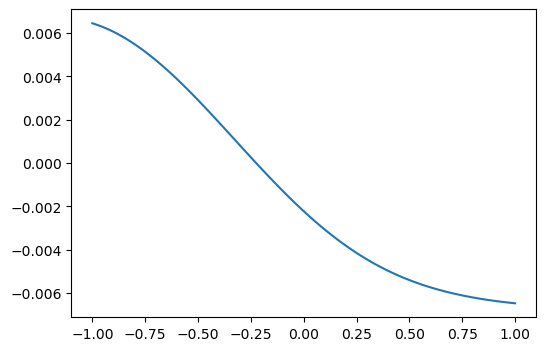

In [321]:
test_x = torch.linspace(0, 1, 100)

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 4))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    ax.plot(test_r.numpy(), observed_pred.mean.numpy())



    # Plot training data as black stars
    #ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    #ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(test_r.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])
